In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cross_validation as cv

from sklearn.cross_validation import KFold

from joblib import Parallel, delayed

from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier

In [86]:
df = pd.read_csv("./../hw1/spam.train.txt", delim_whitespace=True, header=None)
x_data = df.ix[:, 1:].as_matrix(); y_data = df.ix[:, 0].as_matrix()
y_data[y_data == 0] = -1
x_train, x_test, y_train, y_test = cv.train_test_split(x_data, y_data,
                                                       test_size=0.25, random_state=288)


In [87]:
ada_best_params = {'n_estimators': 250, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}

def predict_on_fsubset(features, x_train, x_test, y_train, y_test):
    clf = AdaBoostClassifier(**ada_best_params)
    clf.fit(x_train[:, features], y_train)
    y_pred = clf.predict(x_test[:, features])
    score = f1_score(y_test, y_pred)
    return (clf, score)

In [88]:
def fset2scores(fset, x_train, x_test, y_train, y_test):    
    fpacks = [fset[:i] for i in range(1, len(fset)+1)]
    res = Parallel(n_jobs=8)(delayed(predict_on_fsubset)(pack, x_train, x_test, y_train, y_test) for pack in fpacks)
    
    clfs, scores = zip(*res)
    return clfs, scores

# CFS

In [89]:
from src.cfs import cfs, cfs1

### cfs1

In [90]:
cfs1_features = cfs1(x_train, y_train, x_train.shape[1])

In [92]:
cfs1_clfs, cfs1_scores = fset2scores(cfs1_features, x_train, x_test, y_train, y_test)

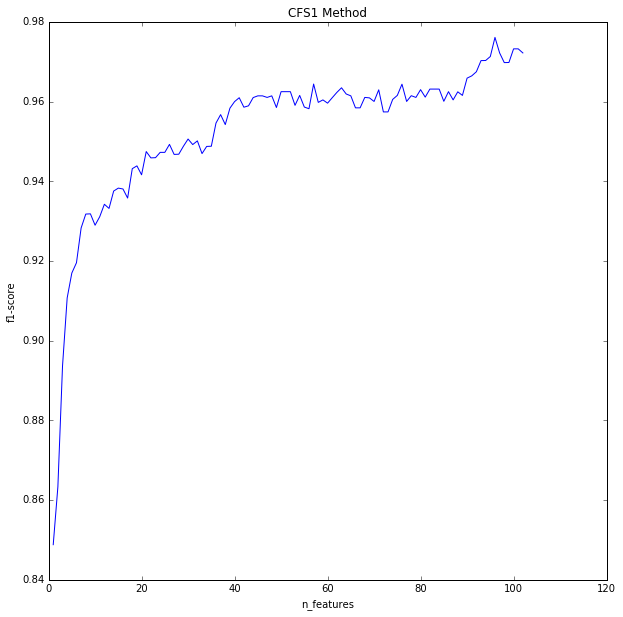

In [105]:
cfs_figure = plt.figure(figsize=(10, 10))
plt.plot(range(1, len(cfs1_features)+1), cfs1_scores)
plt.title('CFS1 Method')

plt.xlabel('n_features')
plt.ylabel('f1-score')
cfs_figure.savefig('cfs_method_score.png')

### cfs2

In [94]:
cfs_features = cfs(x_train, y_train, 1000)

In [95]:
cfs_clfs, cfs_scores = fset2scores(cfs_features, x_train, x_test, y_train, y_test)

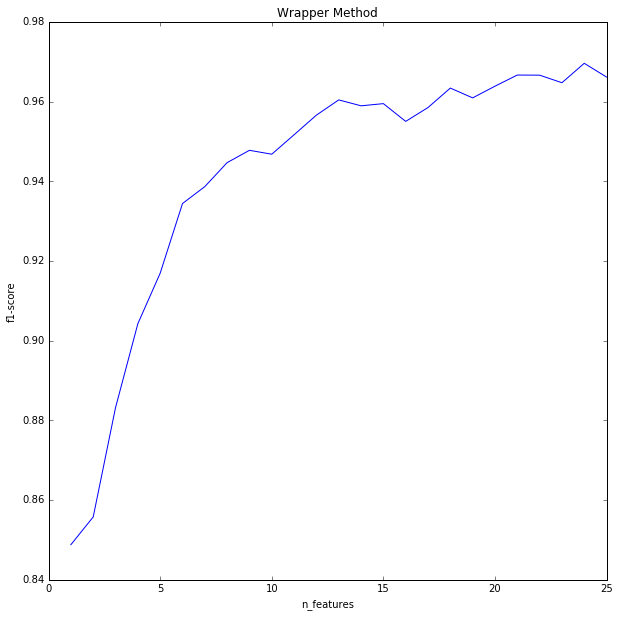

In [96]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, len(cfs_features)+1), cfs_scores)
plt.title('Wrapper Method')

plt.xlabel('n_features')
plt.ylabel('f1-score')

# Wrapper

In [125]:
FOLDS = 4

def fit_pred_abc(X, y, feature_set):
    score = 0
    abc = AdaBoostClassifier(*ada_best_params)
    
    for train_index, test_index in KFold(len(y), n_folds=FOLDS):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        abc.fit(X_train[:, feature_set], y_train)

        y_pred = abc.predict(X_test[:, feature_set])
        score += f1_score(y_test, y_pred)/float(FOLDS)
        
    return score

def fit_abc(x_train, y_train):
    abc = AdaBoostClassifier(n_estimators=50, learning_rate=0.2)
    abc.fit(x_train, y_train)
    return abc

In [132]:
def wrapper(expected_features, x_train, y_train, x_test, y_test):
    initial_fset = set(np.arange(x_train.shape[1]))
    target_flist = list()
    times_list = []
    
    scores = []

    for i in range(expected_features):
        start = time.time()
        print i,
        target_fset = set(target_flist)
        rest_fset = list(initial_fset - target_fset)
        
        unbound_fsets = [list(target_fset|set([f])) for f in rest_fset]
        
#         clfs = Parallel(n_jobs=8)(delayed(fit_abc)(x_train[:, fset], y_train) for fset in unbound_fsets)
#         clfs_scores = [f1_score(y_test, clf.predict(x_test[:, unbound_fsets[i]])) for i, clf in enumerate(clfs)]
        clfs_scores = Parallel(n_jobs=8)(delayed(fit_pred_abc)(x_train, y_train, fset) for fset in unbound_fsets)

        best_f_ind = np.argmax(clfs_scores)

        best_f = rest_fset[best_f_ind]
        target_flist.append(best_f)
        scores.append(clfs_scores[best_f_ind])
        end = time.time()
        times_list.append(end-start)

    return target_flist, scores, times_list

wrapper_features, wrapper_scores,wrapper_times  = wrapper(2, x_train, y_train, x_test, y_test)

0 1


In [133]:
wrapper_features, wrapper_scores, wrapper_times

([48, 53],
 [0.84981641438383315, 0.86643828578385995],
 [37.77843117713928, 39.939043045043945])

In [130]:
wrapper_features, wrapper_scores, wrapper_times

([48, 53],
 [0.84981641438383315, 0.86643828578385995],
 [8.948410987854004, 8.625895023345947])

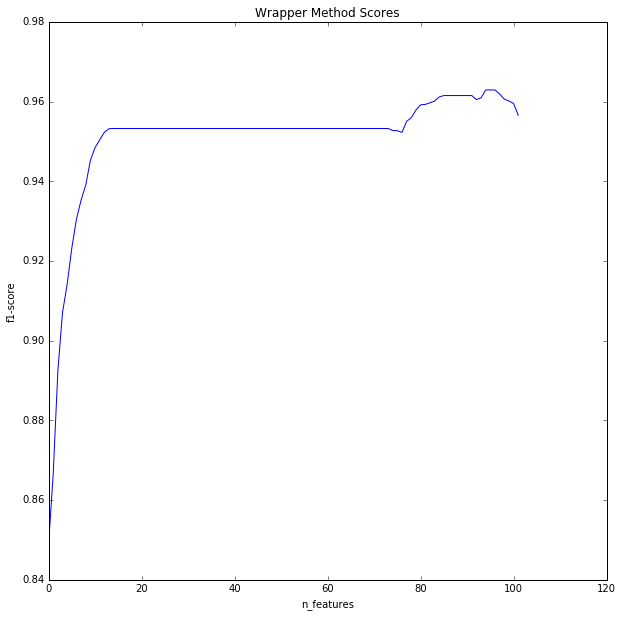

In [103]:
wrapper_fig = plt.figure(figsize=(10, 10))
plt.plot(range(len(wrapper_features)), wrapper_scores)
plt.title('Wrapper Method Scores')

plt.xlabel('n_features')
plt.ylabel('f1-score')
wrapper_fig.savefig('wrapper_method_scores.png')

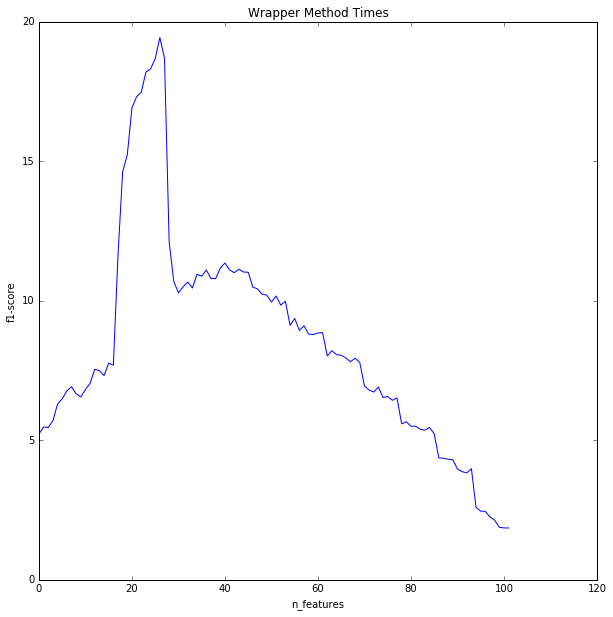

In [104]:
wrapper_fig = plt.figure(figsize=(10, 10))
plt.plot(range(len(wrapper_features)), wrapper_times)
plt.title('Wrapper Method Times')

plt.xlabel('n_features')
plt.ylabel('f1-score')
wrapper_fig.savefig('wrapper_method_times.png')

In [ ]:
len(cfs_features)

In [ ]:
len(wrapper_features)

# Embedded

In [ ]:
f_w = np.zeros(x_train.shape[1])

def wide_walk(tree, feature_weigths):
    if tree.split_feature is None:
        return feature_weigths
    
    feature_weigths[tree.split_feature] += tree.score
    
    feature_weigths = wide_walk(tree.fb, feature_weigths)
    feature_weigths = wide_walk(tree.tb, feature_weigths)
    
    return feature_weigths
wide_walk(gboost.ensembles[3].tree, f_w)
#np.sum(np.array([wide_walk(p.tree, np.zeros(x_train.shape[1])) for p in predictors[0].ensembles]), axis=0)